In [1]:
import pickle
import itertools
import warnings
import sys 
import re
import os
import logging
from multiprocessing import cpu_count
from collections import namedtuple
import html

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ckonlpy.tag import Twitter
from konlpy.tag import Mecab
from konlpy.utils import pprint

from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel, ldaseqmodel, LdaMulticore, lda_dispatcher, doc2vec
from gensim.models.wrappers import LdaMallet, DtmModel
from gensim.corpora import Dictionary, bleicorpus
from gensim.matutils import hellinger
from gensim import corpora, models, similarities
from gensim.models.callbacks import CoherenceMetric, DiffMetric, PerplexityMetric, ConvergenceMetric
from gensim.models.doc2vec import TaggedDocument

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import PCA

import pyLDAvis.gensim

import pylab as pl

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

warnings.filterwarnings('ignore')

In [2]:
ct = Twitter()
mecab = Mecab()
def nav_tokenizer(tagger, corpus, stopwords):
    pos = tagger.pos(corpus)
    pos = ['/'.join(t) for t in pos if not t[0] in stopwords]
    return pos

In [3]:
def MakeTaggedData(df, taggedDoc, tagger, stopwords):
    w2v_docs = list()
    for idx in tqdm(df.index):
        text = df.loc[idx,'title']+'.\n'+df.loc[idx,'mainText']
        pos = nav_tokenizer(tagger, text, stopwords)
        label = ['news_'+str(idx)]
        w2v_docs.append(TaggedDocument(pos, label))
    return w2v_docs

In [4]:
import multiprocessing
cores = int(multiprocessing.cpu_count())
def Make_Doc2Vec_Model(modelPath, data, size, dm, dm_concat, dm_mean, hs, negative, epoch, window, alpha, min_alpha, workers, tagger):
    from tqdm import tqdm
    tqdm.pandas(desc="progress-bar")
    from datetime import datetime
    from gensim.models import doc2vec
    start = datetime.now()
    modelName = 'doc2vec_size-{}_epoch-{}_window-{}_negative-{}_hs-{}_dm-{}_dm_concat-{}_dm_mean-{}_by-{}.model'.format(
        size, epoch, window, negative, hs, dm, dm_concat, dm_mean, tagger)
    modelName = modelPath+modelName
    print (modelName)
    if window!=None:
        d2v_model = doc2vec.Doc2Vec(vector_size = size, dm = dm, dm_concat = dm_concat,
                   dm_mean = dm_mean, negative = negative, hs = hs, window = window,
                   alpha = alpha, min_alpha = min_alpha, workers = workers, epochs= epoch)
    else:
        d2v_model = doc2vec.Doc2Vec(vector_size = size, dm = dm, dm_concat = dm_concat,
                   dm_mean = dm_mean, negative = negative, hs = hs,
                   alpha = alpha, min_alpha = min_alpha, workers = workers, epochs= epoch)
    d2v_model.build_vocab(tqdm(data))
    d2v_model.train_lbls = False # do not train labels of words
    d2v_model.train(tqdm(data), total_examples=d2v_model.corpus_count, epochs=d2v_model.iter)
    
    end = datetime.now()
    d2v_model.save(modelName)
    print ("Total running time: ", end-start)
    return d2v_model
print (cores)

4


In [5]:
ct = Twitter()
mecab = Mecab()
def nav_tokenizer(tagger, corpus, stopwords):
    pos = tagger.pos(corpus)
    pos = ['/'.join(t) for t in pos if not t[0] in stopwords]
    return pos

In [6]:
def Print_Similar_Doc(model, df, infer_vecs, target):
    import re
    intIndex = df.index.tolist().index(target.name)
    print ('* News : {}'.format(target['title']))
    print ('* Press : {}'.format(target['press']))
    print ('* Date : {}'.format(target['date']))
    print ('* Site : {}'.format(target['site']))
    print ()
    infer_vec = infer_vecs[intIndex]
    simDocs = model.docvecs.most_similar(positive = [infer_vec])
    print (' * Similar Document : {}'.format(len(simDocs)))
    simDocs = pd.DataFrame(list(map(lambda x: df.loc[re.split('_', x[0])[1]], simDocs)))
    simDocs = simDocs.loc[:, ['category','date', 'press', 'title', 'keywords', 'extracted_keywords', 'site']]
    return simDocs
    

In [7]:
def ScatterPlot_by_kmeans(n_cluster, model):
    print ('KMeans Clustering')
    print ('Number of Cluster : {}'.format(n_cluster))
    import timeit
    start = timeit.default_timer()
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    kmeans = KMeans(n_clusters = n_cluster, 
                  init = 'k-means++', 
                  max_iter = 500)
    X = kmeans.fit(model.docvecs.doctag_syn0)
    labels = kmeans.labels_.tolist()
    l = kmeans.fit_predict(model.docvecs.doctag_syn0)
    pca = PCA(n_components = 2).fit(model.docvecs.doctag_syn0)
    datapoint = pca.transform(model.docvecs.doctag_syn0)
    centroids = kmeans.cluster_centers_
    centroidpoint = pca.transform(centroids)
    plt.figure
    plt.scatter(datapoint[:, 0], datapoint[:, 1],
                c = labels)
    plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], 
               marker = '^', s = 150, c = '#000000')
    end = timeit.default_timer()
    execution_time = end - start
    print ('Running Time : {}'.format(execution_time))
    

# Stopwords

In [8]:
stopwords = open('./data/stopwordsList.txt',encoding='utf-8').readlines()
stopwords = list(map(lambda x: x.strip(), stopwords))

# News

## Naver

In [9]:
dictNaver = pickle.load(open('./data/pre_data/stastics/for_statistics_Naver_from_mongodb.pickled','rb'))
dfNaver = pd.DataFrame.from_dict(dictNaver, orient='index')
dfNaver['site'] = ['Naver'] * dfNaver.shape[0]
print (dfNaver.shape)

(15120, 11)


## Daum

In [10]:
dictDaum = pickle.load(open('./data/pre_data/stastics/for_statistics_daum_from_mongodb.pickled','rb'))
dfDaum = pd.DataFrame.from_dict(dictDaum, orient='index')
dfDaum['site'] = ['Daum'] * dfDaum.shape[0]
print (dfDaum.shape)

(9372, 11)


## 뉴스기사 통합

In [11]:
combinedDf = pd.concat([dfNaver, dfDaum])
combinedDf.head()

,category,date,press,number_of_comment,number_of_crawled_comment,rank,title,mainText,keywords,extracted_keywords,site
5a29c445588c132954d1973a,정치,2017.12.07,연합뉴스,1713,1465,1,"北외무성 ""전쟁 바라지 않지만 결코 피하지 않을 것""","美고위인사 대북언급 비난하며 ""전쟁 기정사실화"" 위협 며칠 새 이어지는 북한 군민...","[외무성, 핵전쟁, 대변인]","{핵전쟁, 중앙, 대변인, 고위, 미국, 조선반도, 도화선, 북한}",Naver
5a29c445588c132954d1973b,정치,2017.12.07,한국일보,2551,2062,2,"예산전쟁, 예결위 간사ㆍ호남이 웃었다",예결위 간사들이 최대 수혜자..당 지도부 내 몫 챙기기도 여전 황주홍ㆍ김도읍 등...,"[예산, 예결위, soc]","{국민의당, 호남, 지역구, 예산안, 의원, 정부안, 증액}",Naver
5a29c445588c132954d1973c,정치,2017.12.07,뉴시스,610,536,3,"혐의 부인에 20시간 조사…檢, 최경환 구속 카드 꺼내나",【서울=뉴시스】 최진석 기자 = 박근혜 정부 시절 국가정보원 특수활동비 수수 의혹 ...,"[최경환, 구속영장, 국가정보원]","{국정원장, 의원, 혐의, 정기국회, 구속영장 청구, 검찰, 조사}",Naver
5a29c445588c132954d1973d,정치,2017.12.07,연합뉴스,145,133,4,"최재형 감사원장 후보자 ""독립성 강화는 임명권자의 뜻""",감사원장에 내정된 최재형 사법연수원장(고양=연합뉴스) 이희열 기자 = 7일 감사원장...,"[이슈 · 최재형 감사원장 내정, 감사원장, 최재형, 감사원]","{공직 사회, 생활, 후보자, 감사원장, 법관, 지명}",Naver
5a29c445588c132954d1973e,정치,2017.12.07,동아일보,1074,932,5,"B-1B 한반도에 뜨자, 평양 비운 김정은",[동아일보] 북중 접경지 양강도 삼지연 시찰… 방북 유엔 사무차장 면담 안할듯 B-...,"[김정은, b-1b, 한반도]","{공장, 시찰, 삼지연, 펠트먼, 양강도, 훈련, 김정은, 접경, 사무차장}",Naver


## Path

In [12]:
if sys.platform =='darwin':
    clusteringPath ='/Volumes/disk1/Clustering_doc2vec/'
    
elif sys.platform =='win32':
    clusteringPath = 'd:/Clustering_doc2vec/' 

## Document Labeling

In [13]:
TaggedDocument = namedtuple('TaggedDocument', 'words tags')

In [14]:
combinedDf[combinedDf.category == '스포츠']

,category,date,press,number_of_comment,number_of_crawled_comment,rank,title,mainText,keywords,extracted_keywords,site
5a29c445588c132954d1980c,스포츠,2017.12.07,스포츠조선,942,935,1,"채태인-최준석? 삼성 ""우리팀과 안 맞는다""",FA를 신청한 채태인. 스포츠조선DB 올해 스토브리그에서 가장 기민하게 움직인 팀이...,"[채태인, 최준석, 넥센 히어로즈, 롯데 자이언츠]","{구단, 러프, 리그, 영입, 강민호, 삼성, 외국인, 롯데, 투수, 선수}",Naver
5a29c445588c132954d1980d,스포츠,2017.12.07,스포티비뉴스,1759,1752,2,[정철우의 애플베이스볼]최준석 '타구 스피드 1위'에도 외면 받는 이유,▲ 최준석. 한희재 기자 [스포티비뉴스=정철우 기자]최준석은 KBO 리그에서 손...,"[최준석, 롯데 자이언츠]","{이유, 드라이브, 타자, 타구 스피드, 홈런, 최고, 각도, 최준석}",Naver
5a29c445588c132954d1980e,스포츠,2017.12.07,마이데일리,1303,1296,3,"FA 정의윤, 4년 29억원에 SK 잔류",[마이데일리 = 고동현 기자] 정의윤이 SK에 남는다. 프로야구 SK 와이번스는 ...,[정의윤],"{계약, SK 와이번스, 출전, 홈런, 타점, 정의윤, 이적, 타율, 경기}",Naver
5a29c445588c132954d1980f,스포츠,2017.12.07,스포츠조선,395,390,4,"[UCL현장리뷰]'손흥민 6호골' 토트넘, 아포엘에 3대0 승리",AFPBBNews = News1 [웸블리(영국 런던)=이건 스포츠조선닷컴 기자]손흥...,[손흥민],"{승리, 슈팅, AFPBBNews, 전반, 손흥민, 아포엘, 토트넘, 경기, 후반}",Naver
5a29c445588c132954d19810,스포츠,2017.12.07,연합뉴스,444,441,5,"푸틴 ""평창 올림픽 보이콧 안해…개인자격 출전 막지 않을 것""(종합)","푸틴 ""평창올림픽 보이콧 안한다…개인자격 출전 막지 않아""(모스크바 AP=연합뉴스)...","[블라디미르 푸틴, 보이콧, 평창올림픽]","{결정, 올림픽, 출전, 푸틴, 대통령, 개인 자격, 러시아, 보이콧}",Naver
5a29c445588c132954d19811,스포츠,2017.12.07,스포츠조선,355,353,6,"[UCL현장인터뷰]'시즌 6호골' 손흥민의 배고픔 ""부족한 부분이 있다""",[웸블리(영국 런던)=이건 스포츠조선닷컴 기자]여전히 손흥민(토트넘)은 배가 고팠다...,"[손흥민, 토트넘 핫스퍼 FC]","{위치, 욕심, 손흥민, 선수들, 영국 런던, 프리킥, 토트넘, 경기}",Naver
5a29c445588c132954d19812,스포츠,2017.12.07,인터풋볼,204,204,7,"[UCL 리뷰] '전반만 2실점' 맨시티, 개막 23G 만에 '첫 패'",[인터풋볼] 서재원 기자= 맨체스터 시티가 샤흐타르 도네츠크 원정에서 개막 후 23...,NaN,"{슈팅, 샤흐타르, 맨시티, 전반, 기록, 개막, 경기, 후반, 공격}",Naver
5a29c445588c132954d19813,스포츠,2017.12.07,스포츠월드,594,587,8,"[SW포커스]옵션 포함 총액 29억, SK는 왜 정의윤을 붙잡았나?",[스포츠월드=정세영 기자] FA 정의윤(31)이 SK에 잔류했다. SK는 7일 오후...,NaN,"{계약, FA, 선수, 협상, 옵션, 정의윤과, SK는}",Naver
5a29c445588c132954d19814,스포츠,2017.12.07,OSEN,495,493,9,"[단독] 삼성 강민호, 내년부터 개인 트레이너둔다",[OSEN=손찬익 기자] 삼성 라이온즈 포수 강민호가 내년 시즌 개인 트레이너를 고...,[강민호],"{트레이너 고용, 개인 트레이너, 컨디션, 트레이너의, 강민호, 삼성, 제광성, 선수}",Naver
5a29c445588c132954d19815,스포츠,2017.12.07,노컷뉴스,483,482,10,'옵션만 40% 넘네?' SK-정의윤의 독특한 FA 계약,[CBS노컷뉴스 임종률 기자] 7일 SK와 4년 총액 29억 원에 계약한 외야수 정...,"[정의윤, SK 와이번스]","{SK, 계약, FA, 총액, 정의윤, 외야수, 옵션, 동기, 타율, 선수}",Naver


## Twitter

### Doc2Vec 기본 포맷으로 변경

In [15]:
tagger_ct = 'ct'
filename_ct = clusteringPath+'predata_doc2vec_{}'.format(tagger_ct)
if os.path.isfile(filename_ct):
    w2v_docs_ct = pickle.load(open(filename_ct, 'rb'))
else:
    w2v_docs_ct = MakeTaggedData(combinedDf, TaggedDocument, ct, stopwords)
    pickle.dump(w2v_docs_ct, open(filename_ct,'wb'))

### Doc2Vec Model1 Using Tagger Twitter

In [16]:
%%time
#PV-DM W/
modelName1_ct = clusteringPath + 'doc2vec_size-300_epoch-20_window-5_negative-7_hs-0_dm-1_dm_concat-1_dm_mean-0_by-ct.model'
if not os.path.isfile(modelName1_ct):
    d2v_model1_ct = Make_Doc2Vec_Model(modelPath=clusteringPath, data=w2v_docs_ct, size = 300, dm = 1, dm_concat = 1,
                   dm_mean = 0, negative = 7, hs = 0, epoch = 20, window = 5,
                   alpha = 0.025, min_alpha = 0.025, workers = cores, tagger = 'ct')
else:
    d2v_model1_ct = doc2vec.Doc2Vec.load(modelName1_ct)

CPU times: user 1.1 s, sys: 1.5 s, total: 2.6 s
Wall time: 11.8 s


In [17]:
m1_ct_name = modelName1_ct+'-infer_vector'
if not os.path.isfile(m1_ct_name):
    X_d2v_1_ct = [ d2v_model1_ct.infer_vector(x.words) for x in tqdm(w2v_docs_ct)]
    pickle.dump(X_d2v_1_ct, open(m1_ct_name, 'wb'))
else:
    X_d2v_1_ct = pickle.load(open(m1_ct_name, 'rb'))

In [18]:
test_1_ct = Print_Similar_Doc(d2v_model1_ct, combinedDf, X_d2v_1_ct, combinedDf.loc['5a381bb0588c13417c9a01a3'])
test_1_ct

* News : 안보전략硏 "황병서·김원홍 '처벌'…공포통치 끝 아닌 시작"
* Press : 뉴시스
* Date : 2017.12.18
* Site : Naver

 * Similar Document : 10


,category,date,press,title,keywords,extracted_keywords,site
5a643bd3588c133f28b9ffeb,정치,2018.01.05,동아일보,순간 허점 찌르는 ‘돌부처’… 상대 기선제압 능한 ‘핏대’,NaN,"{통일부 장관, 회담, 위원장, 고위급, 협상, 군사, 2011, 남북}",Naver
5a722b24588c130c4468c15c,뉴스,2018.01.31,조선일보,"북한 가는 우리 비행기, 항공사 전체가 美제재 받을 수도",NaN,"{정부, 마식령 스키장, 비행기, 훈련, 미국, 대북 제재, 북한}",Daum
5a725011588c13318c7ab055,정치,2018.01.31,서울신문,"北, 한·미 훈련재개 보도에 불만 표출… ‘황색바람’ 우려도",NaN,"{마식령 스키장, 금강산 행사, 북측, 훈련, 북한, 남북}",Naver
5a6afb09588c133fb800fa8d,세계,2018.01.25,연합뉴스,"美, 한달만에 고강도 대북제재…'최대 압박' 의지 재확인",NaN,"{경제, 평창동계올림픽, 제재, 재무부, 원유, 압박, 무역, 미국, 북한}",Naver
5a6a7d5b588c133300ec4b3b,뉴스,2018.01.25,국민일보,"[단독] 오청성, 음주운전 사고 내고 우발적 귀순",[이슈 · JSA 초소 북한군 귀순],"{국정원, 정보, 음주운전 사고, 진술, 오씨, 북한, 귀순, 우발적}",Daum
5a2a3ae1588c134d58538e93,정치,2017.12.01,국민일보,"JSA 귀순병사, 북한군 고위급 장교 아들로 ‘엘리트 계층’","[국회의원세비, 섀도보팅, 국가정보원]","{간부, 양말, 운전병, 오씨, 탈북, 장교, 북한, 귀순, 엘리트}",Naver
5a64747e588c1352342d5c90,정치,2018.01.09,뉴스1,"2년만에 마주앉는 남북, 한반도정세 변곡점 만든다…시작은 평창",NaN,"{평창, 합의, 회담, 고위급, 남북관계 개선}",Naver
5a659495588c1307ec1383b2,뉴스,2018.01.20,뉴스1,"통일부 ""北, 예술단 사전점검단 내일 육로로 파견 통보""",NaN,"{통일부, 사전 점검단, 파견, 예술단, 당국자, 북측, 육로}",Daum
5a47e340588c1332c067911e,정치,2017.12.30,조선일보,北 석탄 수출항은 '맨바닥',"[석탄, 위성사진, 대북제재]","{금지, 위성사진, 항구, 북한, 석탄 수출, 모습, 유엔, VOA}",Naver
5a469506588c13000865e494,세계,2017.12.29,중앙일보,"유엔 안보리, 北선박 4척 국제항구 접근 금지 조치","[석탄, 유엔, 안보리]","{4척, 제재, 석탄, 야적, 항구, 선박, 모습, 북한, VOA}",Naver


KMeans Clustering
Number of Cluster : 30
Running Time : 63.609192173999986


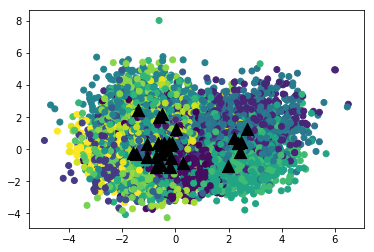

In [19]:
ScatterPlot_by_kmeans(30, d2v_model1_ct)

### Doc2Vec Model2 Using Tagger Twitter

In [20]:
%%time
#PV-DM w/
modelName2_ct = clusteringPath + 'doc2vec_size-300_epoch-20_window-10_negative-7_hs-0_dm-1_dm_concat-0_dm_mean-1_by-ct.model'
if not os.path.isfile(modelName2_ct):
    d2v_model2_ct = Make_Doc2Vec_Model(modelPath=clusteringPath, data=w2v_docs_ct, size = 300, dm = 1, dm_concat = 0,
                   dm_mean = 1, negative = 7, hs = 0, epoch = 20, window = 10,
                   alpha = 0.025, min_alpha = 0.025, workers = cores, tagger = 'ct')
else:
    d2v_model2_ct = doc2vec.Doc2Vec.load(modelName2_ct)

CPU times: user 1.39 s, sys: 2.09 s, total: 3.47 s
Wall time: 5.94 s


In [21]:
m2_ct_name = modelName2_ct+'-infer_vector'
if not os.path.isfile(m2_ct_name):
    X_d2v_2_ct = [ d2v_model2_ct.infer_vector(x.words) for x in tqdm(w2v_docs_ct)]
    pickle.dump(X_d2v_2_ct, open(m2_ct_name, 'wb'))
else:
    X_d2v_2_ct = pickle.load(open(m2_ct_name, 'rb'))

In [22]:
test_2_ct = Print_Similar_Doc(d2v_model2_ct, combinedDf, X_d2v_2_ct, combinedDf.loc['5a381bb0588c13417c9a01a3'])
test_2_ct

* News : 안보전략硏 "황병서·김원홍 '처벌'…공포통치 끝 아닌 시작"
* Press : 뉴시스
* Date : 2017.12.18
* Site : Naver

 * Similar Document : 10


,category,date,press,title,keywords,extracted_keywords,site
5a381bb0588c13417c9a01a3,정치,2017.12.18,뉴시스,"안보전략硏 ""황병서·김원홍 '처벌'…공포통치 끝 아닌 시작""","[황병서, 김원홍, 김정은]","{경제, 처벌, 위원장, 전략연, 부문, 가능성, 김정은, 엘리트, 북한}",Naver
5a3962f0588c130c0c003ec6,정치,2017.12.19,국민일보,北 권력투쟁 심각… 황병서 ‘강등’ 김원홍 ‘농장행’ 김설송 ‘부각’,"[황병서, 노동당, 김원홍]","{김정일, 부국장, 처벌, 노동당, 위원장, 군부, 김정은, 북한}",Naver
5a3ffa90588c133018bcd26d,뉴스,2017.12.24,노컷뉴스,"北 김정은 ""지금까지 시작에 불과, 인민위한 많은 신사업 구상 중""","[김정은, 세포위원장, 노동당]","{조직, 당세포, 노동당, 대회, 위원장, 사업, 관철, 김정은}",Daum
5a3c1de4588c132d5055a5f3,정치,2017.12.21,연합뉴스,"합참 ""오늘 북한군 병사 1명 귀순""(1보)","[귀순, 북한군]","{최신 유행 트렌드, 병사 귀순, 문의, 북한군}",Naver
5a4a95f6588c13385826597c,정치,2018.01.01,연합뉴스,"北김정은 ""美전역 우리 사정권…핵 단추, 내 사무실 책상위에""","[이슈 · 김정은 신년사, 김정은, 조선중앙tv, 핵무기]","{북한 노동당 위원장, 국가, 김정은, 미국, 완성}",Naver
5a3c1de4588c132d5055a5db,정치,2017.12.21,머니투데이,"합참 ""北병사 귀순 후 북측 지역서 수발 총성...아군 지역 피해 현재 없어""(2보)","[귀순, 합동참모본부]","{치어리더 레이싱걸, 무료, 리얼타임 무단 전재}",Naver
5a308ea7588c1349304eefcc,뉴스,2017.12.12,중앙일보,"[단독] 北 실세 황병서 출당, 김원홍은 수용소 끌려갔다","[황병서, 출당, 김원홍]","{숙청 피바람, 김원홍, 규율 위반, 김정은, 소식통, 지휘}",Daum
5a64fa20588c135968bec3a9,정치,2018.01.11,아시아경제,"北, '2인자' 최룡해 당 조직지도부장 임명(상보)",NaN,"{조직, 김정일, 노동당, 위원장, 김정은, 최룡해, 정경택, 북한}",Naver
5a3962f0588c130c0c003ec4,정치,2017.12.19,세계일보,[뉴스+] 금수산궁전 혼자 간 김정은…신변안전 의식? 존재감 과시?,"[김정은, 김정일, 김일성]","{김정일, 김일성, 단독, 위원장, 연구원, 가능성, 정찰, 김정은, 참배, 북한}",Naver
5a3da532588c1323acee81ab,경제,2017.12.22,뉴스1,'경영비리' 신격호 징역 4년…신동빈 징역 1년8개월·집유 2년(1보),"[신격호, 신동빈, 경영비리]","{평창, 채널, 코리아, 금지, 무단 전재, 제보}",Naver


KMeans Clustering
Number of Cluster : 30
Running Time : 69.68501513000001


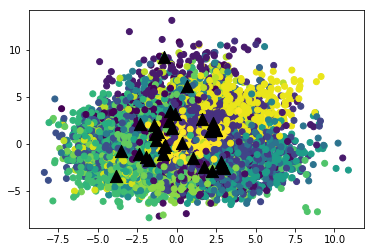

In [36]:
ScatterPlot_by_kmeans(30, d2v_model2_ct)

### Doc2Vec Model3 Using Tagger Twitter

In [23]:
%%time
# PV - DBOW
modelName3_ct = clusteringPath + 'doc2vec_size-300_epoch-20_window-None_negative-7_hs-0_dm-0_dm_concat-0_dm_mean-0_by-ct.model'
if not os.path.isfile(modelName3_ct):
    d2v_model3_Ct = Make_Doc2Vec_Model(modelPath=clusteringPath, data=w2v_docs_ct, size = 300, dm = 0, dm_concat = 0,
                   dm_mean = 0, negative = 7, hs = 0, epoch = 20, window = None,
                   alpha = 0.025, min_alpha = 0.025, workers = cores, tagger = 'ct')
else:
    d2v_model3_ct = doc2vec.Doc2Vec.load(modelName3_ct)

CPU times: user 1.3 s, sys: 811 ms, total: 2.11 s
Wall time: 4.17 s


In [24]:
m3_ct_name = modelName3_ct+'-infer_vector'
if not os.path.isfile(m3_ct_name):
    X_d2v_3_ct = [ d2v_model3_ct.infer_vector(x.words) for x in tqdm(w2v_docs_ct)]
    pickle.dump(X_d2v_3_ct, open(m3_ct_name, 'wb'))
else:
    X_d2v_3_ct = pickle.load(open(m3_ct_name, 'rb'))
    

In [25]:
test_3_ct = Print_Similar_Doc(d2v_model3_ct, combinedDf, X_d2v_3_ct, combinedDf.loc['5a381bb0588c13417c9a01a3'])
test_3_ct

* News : 안보전략硏 "황병서·김원홍 '처벌'…공포통치 끝 아닌 시작"
* Press : 뉴시스
* Date : 2017.12.18
* Site : Naver

 * Similar Document : 10


,category,date,press,title,keywords,extracted_keywords,site
5a381bb0588c13417c9a01a3,정치,2017.12.18,뉴시스,"안보전략硏 ""황병서·김원홍 '처벌'…공포통치 끝 아닌 시작""","[황병서, 김원홍, 김정은]","{경제, 처벌, 위원장, 전략연, 부문, 가능성, 김정은, 엘리트, 북한}",Naver
5a3962f0588c130c0c003ec6,정치,2017.12.19,국민일보,北 권력투쟁 심각… 황병서 ‘강등’ 김원홍 ‘농장행’ 김설송 ‘부각’,"[황병서, 노동당, 김원홍]","{김정일, 부국장, 처벌, 노동당, 위원장, 군부, 김정은, 북한}",Naver
5a400870588c133fcc6bc83e,정치,2017.12.24,세계일보,‘유류 트리거’ 발동땐 경제 치명타… 벼랑끝 北 남은 선택은?,"[이슈 · 국제사회, 대북 압박 강화, 유엔, 김정은, 대북제재]","{대북, 안보리, 제재, 위원장, 신년사, 유엔, 북한, 결의, 도발}",Naver
5a3962f0588c130c0c003ec4,정치,2017.12.19,세계일보,[뉴스+] 금수산궁전 혼자 간 김정은…신변안전 의식? 존재감 과시?,"[김정은, 김정일, 김일성]","{김정일, 김일성, 단독, 위원장, 연구원, 가능성, 정찰, 김정은, 참배, 북한}",Naver
5a69c7e294f9255806501497,사회,2018.01.24,연합뉴스,"김명수 대법원장 ""법원행정처 개편할 것…대외업무 전면 재검토""(속보)",NaN,"{전면, 김명수 대법원장 법원행정처 개편}",Naver
5a2d8322588c1358bcf3ed79,세계,2017.12.10,뉴시스,"중국 전략핵잠수함 총출동...북한 정세 악화에 ""전비태세 수행""","[탄도미사일, slbm, icbm]","{발사, 기지, 중국, 싼야, 전략 핵잠수함, 탄도 미사일}",Naver
5a381bb0588c13417c9a021d,세계,2017.12.18,뉴시스,"북한, '3차세계대전 발발 가능 지역 ' 2년 연속 1위","[우크라이나, 대만, 나토]","{안보, 외교, 교수, 지역, 가능성, 군사, 미국, 전쟁, 북한, 상황}",Naver
5a2ec677588c1360805f8a13,정치,2017.12.11,뉴시스,"[속보]법원, 최경환 체포동의서 검찰 발송","[최경환, 체포동의, 검찰]","{서울, 네이버 채널, 공감 언론 통신사, 주가, 빅데이터}",Naver
5a381bb0588c13417c9a01ac,정치,2017.12.18,세계일보,[뉴스+] 금수산궁전 혼자 간 김정은…신변안전 의식? 존재감 과시?,"[김정은, 김정일, 김일성]","{김정일, 김일성, 단독, 위원장, 연구원, 가능성, 정찰, 김정은, 참배, 북한}",Naver
5a64768b588c1308781331b8,정치,2018.01.08,뉴시스,"통일부 ""남북회담 9일 오전 10시 개시…수석대표 권한 부여""",NaN,"{통일부, 개시, 회담, 중심, 대변인, 부분, 확정, 회의, 남북}",Naver


KMeans Clustering
Number of Cluster : 30
Running Time : 77.68117893500005


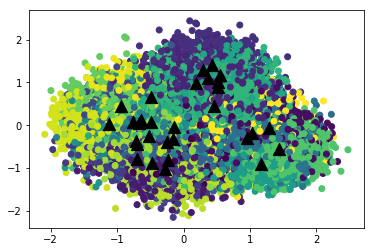

In [37]:
ScatterPlot_by_kmeans(30, d2v_model3_ct)

# Mecab

In [26]:
tagger_mecab = 'mecab'
filename_mecab = clusteringPath+'predata_doc2vec_{}'.format(tagger_mecab)
if os.path.isfile(filename_mecab):
    w2v_docs_mecab = pickle.load(open(filename_mecab, 'rb'))
else:
    w2v_docs_mecab = MakeTaggedData(combinedDf, TaggedDocument, mecab, stopwords)
    pickle.dump(w2v_docs_mecab, open(filename_mecab,'wb'))

### Doc2Vec Model1 Using Tagger Mecab

In [27]:
%%time
#PV-DM W/
modelName1_mecab = clusteringPath + 'doc2vec_size-300_epoch-20_window-5_negative-7_hs-0_dm-1_dm_concat-1_dm_mean-0_by-mecab.model'
if not os.path.isfile(modelName1_mecab):
    d2v_model1_mecab = Make_Doc2Vec_Model(modelPath=clusteringPath, data=w2v_docs_mecab, size = 300, dm = 1, dm_concat = 1,
                   dm_mean = 0, negative = 7, hs = 0, epoch = 20, window = 5,
                   alpha = 0.025, min_alpha = 0.025, workers = cores, tagger = 'mecab')
else:
    d2v_model1_mecab = doc2vec.Doc2Vec.load(modelName1_mecab)

CPU times: user 645 ms, sys: 1.6 s, total: 2.24 s
Wall time: 12.3 s


In [28]:
m1_mecab_name = modelName1_mecab+'-infer_vector'
if not os.path.isfile(m1_mecab_name):
    X_d2v_1_mecab = [ d2v_model1_mecab.infer_vector(x.words) for x in tqdm(w2v_docs_mecab)]
    pickle.dump(X_d2v_1_mecab, open(m1_mecab_name, 'wb'))
else:
    X_d2v_1_mecab = pickle.load(open(m1_mecab_name, 'rb'))

In [29]:
test_1_mecab = Print_Similar_Doc(d2v_model1_mecab, combinedDf, X_d2v_1_mecab, combinedDf.loc['5a381bb0588c13417c9a01a3'])
test_1_mecab

* News : 안보전략硏 "황병서·김원홍 '처벌'…공포통치 끝 아닌 시작"
* Press : 뉴시스
* Date : 2017.12.18
* Site : Naver

 * Similar Document : 10


,category,date,press,title,keywords,extracted_keywords,site
5a381bb0588c13417c9a021d,세계,2017.12.18,뉴시스,"북한, '3차세계대전 발발 가능 지역 ' 2년 연속 1위","[우크라이나, 대만, 나토]","{안보, 외교, 교수, 지역, 가능성, 군사, 미국, 전쟁, 북한, 상황}",Naver
5a32fedb588c1336907de4f6,스포츠,2017.12.14,MK스포츠,"北 ""동아시안컵 상금 몰수 사전 통보 없었다""",NaN,"{상금, 대회, 동아시안컵, 야후 재팬, EAFF, 일본, 여성부, 북한}",Daum
5a725011588c13318c7ab0e1,세계,2018.01.31,연합뉴스,"주북 러 대사 ""북한, 석유제품 중단 전쟁선포로 받아들일 것""(종합)",NaN,"{러시아 대사, 중단, 석유 제품, 공급, 북한, 상황}",Naver
5a65fae8588c132538ecc145,정치,2018.01.15,뉴스1,남북대화 전면에 나온 현송월…미소 띤 모습으로 등장,"[이슈 · 남북, 고위급 회담]","{평창, 파견, 모란봉 악단, 예술단, 단장, 현송월, 북한}",Naver
5a4a95f6588c133858265a0b,세계,2018.01.01,연합뉴스,"독일 외무 ""북핵 대응 실패시 다른 국가도 북한 뒤이을 것""","[북핵, 핵무기, 독일]","{대응, 핵무기 보유, 독일, 장관, 인명, 가브리엘, 북한 핵무기}",Naver
5a645f47588c135340a9d634,정치,2018.01.02,연합뉴스,"北, 회담 제안 뒤 판문점 연락채널 통화시도에도 무반응",NaN,"{통일부, 판문점 연락관, 채널, 고위급, 당국 회담, 시도, 남북}",Naver
5a64fa20588c135968bec3a9,정치,2018.01.11,아시아경제,"北, '2인자' 최룡해 당 조직지도부장 임명(상보)",NaN,"{조직, 김정일, 노동당, 위원장, 김정은, 최룡해, 정경택, 북한}",Naver
5a3ec066588c1341c0b7cc52,세계,2017.12.23,연합뉴스,"북한 대사 추방한 페루, 외교관 2명 더 쫓아내","[페루, 외교관, 외교부]","{외교관 2명, 페루 외교부, 추방, 대사, 북한, 주재}",Naver
5a660bec588c131290205e52,뉴스,2018.01.18,연합뉴스,"북 ""조선민주주의인민공화국으로 불러달라""..미국에 사과요구",NaN,"{명칭, 유엔 주재, 북한 대표부, 미국, 참사관}",Daum
5a308ea7588c1349304eefcc,뉴스,2017.12.12,중앙일보,"[단독] 北 실세 황병서 출당, 김원홍은 수용소 끌려갔다","[황병서, 출당, 김원홍]","{숙청 피바람, 김원홍, 규율 위반, 김정은, 소식통, 지휘}",Daum


KMeans Clustering
Number of Cluster : 30
Running Time : 59.63285036299999


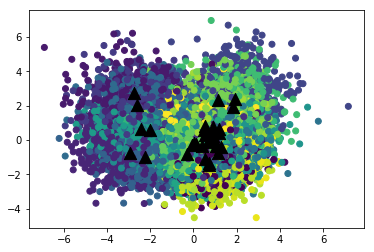

In [38]:
ScatterPlot_by_kmeans(30, d2v_model1_mecab)

### Doc2Vec Model2 Using Tagger Mecab

In [30]:
%%time
#PV-DM w/
modelName2_mecab = clusteringPath + 'doc2vec_size-300_epoch-20_window-10_negative-7_hs-0_dm-1_dm_concat-0_dm_mean-1_by-mecab.model'
if not os.path.isfile(modelName2_mecab):
    d2v_model2_mecab = Make_Doc2Vec_Model(modelPath=clusteringPath, data=w2v_docs_mecab, size = 300, dm = 1, dm_concat = 0,
                   dm_mean = 1, negative = 7, hs = 0, epoch = 20, window = 10,
                   alpha = 0.025, min_alpha = 0.025, workers = cores, tagger = 'mecab')
else:
    d2v_model2_mecab = doc2vec.Doc2Vec.load(modelName2_mecab)

CPU times: user 3.16 s, sys: 9.39 s, total: 12.6 s
Wall time: 17.7 s


In [31]:
m2_mecab_name = modelName2_mecab+'-infer_vector'
if not os.path.isfile(m2_mecab_name):
    X_d2v_2_mecab = [ d2v_model2_mecab.infer_vector(x.words) for x in tqdm(w2v_docs_mecab)]
    pickle.dump(X_d2v_2_mecab, open(m2_mecab_name, 'wb'))
else:
    X_d2v_2_mecab = pickle.load(open(m2_mecab_name, 'rb'))

In [32]:
test_2_mecab = Print_Similar_Doc(d2v_model2_mecab, combinedDf, X_d2v_2_mecab, combinedDf.loc['5a381bb0588c13417c9a01a3'])
test_2_mecab

* News : 안보전략硏 "황병서·김원홍 '처벌'…공포통치 끝 아닌 시작"
* Press : 뉴시스
* Date : 2017.12.18
* Site : Naver

 * Similar Document : 10


,category,date,press,title,keywords,extracted_keywords,site
5a381bb0588c13417c9a01a3,정치,2017.12.18,뉴시스,"안보전략硏 ""황병서·김원홍 '처벌'…공포통치 끝 아닌 시작""","[황병서, 김원홍, 김정은]","{경제, 처벌, 위원장, 전략연, 부문, 가능성, 김정은, 엘리트, 북한}",Naver
5a31691f588c1331140facf0,정치,2017.12.13,연합뉴스,베일 벗은 北 핵·미사일 '새 라인업'…수장은 태종수,"[미사일, 노동당, 김정은]","{노동당, 대회, 위원장, 군수 공업, 개발, 태종수, 북한}",Naver
5a387c6b588c130ae49af563,연예,2017.12.18,스타뉴스,"샤이니 종현, 오늘(18일) 숨진 채 발견",[샤이니종현],"{금지, 샤이니 종현, 18일, 리얼타임, 발견, 속보, 문완식}",Daum
5a3962f0588c130c0c003ec4,정치,2017.12.19,세계일보,[뉴스+] 금수산궁전 혼자 간 김정은…신변안전 의식? 존재감 과시?,"[김정은, 김정일, 김일성]","{김정일, 김일성, 단독, 위원장, 연구원, 가능성, 정찰, 김정은, 참배, 북한}",Naver
5a2a3ae1588c134d58538e85,정치,2017.12.01,경향신문,[북 ‘화성-15형’ 미사일 발사]‘핵’ 뒤로 돌리고…‘경제’로 눈 돌릴 듯,"[화성-15형, 미사일발사, icbm]","{경제, 제재, 건설, 강국, 해제, 완성, 북한, 병진}",Naver
5a3c1de4588c132d5055a604,경제,2017.12.21,연합뉴스,"이주열 ""돌발변수 없으면 내년 잠재성장률 수준 성장할 것""","[이주열, 잠재성장률, 금리인상]","{잠재, 보호무역, 경제, 한국은행 총재, 북한 리스크, 글로벌, 주요, 21}",Naver
5a41525a588c133f8cfd0cbe,세계,2017.12.25,연합뉴스,"중 전문가들 ""안보리 제재 북한에 큰 타격…근간 흔들긴 어려워""","[안보리제재, 대북제재, 유엔안전보장이사회]","{경제, 타격, 연구원, 대북 제재, 석유, 공급, 북한}",Naver
5a2c53cd588c1304acddf6c7,정치,2017.12.09,뉴스1,백두산 오른 김정은…핵무력 완성·핵보유국 선언 임박?,"[김정은, 백두산, 핵보유국]","{김정일, 성산, 김정은 위원장, 혁명, 백두산 방문, 북한}",Naver
5a4a95f6588c13385826597c,정치,2018.01.01,연합뉴스,"北김정은 ""美전역 우리 사정권…핵 단추, 내 사무실 책상위에""","[이슈 · 김정은 신년사, 김정은, 조선중앙tv, 핵무기]","{북한 노동당 위원장, 국가, 김정은, 미국, 완성}",Naver
5a4ab0cd588c131048976885,뉴스,2018.01.01,연합뉴스,"北김정은 ""평창올림픽 대표단 파견용의..남북 당국 만날 수도""","[김정은, 평창올림픽, 평창동계올림픽]","{노동당 위원장, 파견, 북남, 김정은, 미국, 상태, 북한}",Daum


KMeans Clustering
Number of Cluster : 30
Running Time : 69.997017959


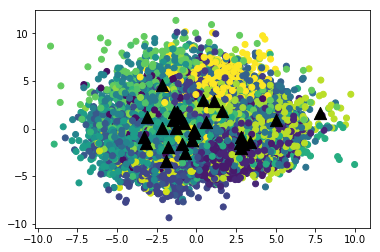

In [39]:
ScatterPlot_by_kmeans(30, d2v_model2_mecab)

### Doc2Vec Model3 Using Tagger Mecab

In [33]:
%%time
# PV - DBOW
modelName3_mecab = clusteringPath + 'doc2vec_size-300_epoch-20_window-None_negative-7_hs-0_dm-0_dm_concat-0_dm_mean-0_by-mecab.model'
if not os.path.isfile(modelName3_mecab):
    d2v_model3_mecab = Make_Doc2Vec_Model(modelPath=clusteringPath, data=w2v_docs_mecab, size = 300, dm = 0, dm_concat = 0,
                   dm_mean = 0, negative = 7, hs = 0, epoch = 20, window = None,
                   alpha = 0.025, min_alpha = 0.025, workers = cores, tagger = 'mecab')
else:
    d2v_model3_mecab = doc2vec.Doc2Vec.load(modelName3_mecab)

CPU times: user 694 ms, sys: 401 ms, total: 1.1 s
Wall time: 3.09 s


In [34]:
m3_mecab_name = modelName3_mecab+'-infer_vector'
if not os.path.isfile(m3_mecab_name):
    X_d2v_3_mecab = [ d2v_model3_mecab.infer_vector(x.words) for x in tqdm(w2v_docs_mecab)]
    pickle.dump(X_d2v_3_mecab, open(m3_mecab_name, 'wb'))
else:
    X_d2v_3_mecab = pickle.load(open(m3_mecab_name, 'rb'))

In [35]:
test_3_mecab = Print_Similar_Doc(d2v_model3_mecab, combinedDf, X_d2v_3_mecab, combinedDf.loc['5a381bb0588c13417c9a01a3'])
test_3_mecab

* News : 안보전략硏 "황병서·김원홍 '처벌'…공포통치 끝 아닌 시작"
* Press : 뉴시스
* Date : 2017.12.18
* Site : Naver

 * Similar Document : 10


,category,date,press,title,keywords,extracted_keywords,site
5a381bb0588c13417c9a01a3,정치,2017.12.18,뉴시스,"안보전략硏 ""황병서·김원홍 '처벌'…공포통치 끝 아닌 시작""","[황병서, 김원홍, 김정은]","{경제, 처벌, 위원장, 전략연, 부문, 가능성, 김정은, 엘리트, 북한}",Naver
5a643bd3588c133f28b9ffe3,정치,2018.01.05,뉴시스,2년 만의 南北회담…'평창'에 '개성·금강산'도 테이블에,NaN,"{평창, 전망, 회담, 고위급, 북측, 북한, 남측, 남북}",Naver
5a3962f0588c130c0c003ec6,정치,2017.12.19,국민일보,北 권력투쟁 심각… 황병서 ‘강등’ 김원홍 ‘농장행’ 김설송 ‘부각’,"[황병서, 노동당, 김원홍]","{김정일, 부국장, 처벌, 노동당, 위원장, 군부, 김정은, 북한}",Naver
5a469506588c13000865e499,세계,2017.12.29,연합뉴스,중국 대북제재 '후폭풍'…북중무역거점 단둥 내년초 '개점휴업',"[대북제재, 단둥, 개점휴업]","{북중 교역, 중국, 북한, 무역, 단둥, 대북 제재, 유엔}",Naver
5a3962f0588c130c0c003ec4,정치,2017.12.19,세계일보,[뉴스+] 금수산궁전 혼자 간 김정은…신변안전 의식? 존재감 과시?,"[김정은, 김정일, 김일성]","{김정일, 김일성, 단독, 위원장, 연구원, 가능성, 정찰, 김정은, 참배, 북한}",Naver
5a64fa20588c135968bec3a9,정치,2018.01.11,아시아경제,"北, '2인자' 최룡해 당 조직지도부장 임명(상보)",NaN,"{조직, 김정일, 노동당, 위원장, 김정은, 최룡해, 정경택, 북한}",Naver
5a667575588c134e0848db5f,세계,2018.01.20,뉴시스,"[종합]美 새 국방전략,중·러 초점…매티스 ""北·이란, 전 세계 위협'",NaN,"{이란, 세계, 방위 전략, 국가 방위, 미국, 북한, 위협}",Naver
5a4936c6588c1304344641bd,세계,2017.12.31,연합뉴스,"""北 황병서 처벌은 뇌물문제·최룡해와 대립 결과""","[황병서, 최룡해, 김정은]","{처벌, 국장, 20, 검열, 김정은 위원장, 최룡해, 황병서, 북한}",Naver
5a29d24d588c1367a0424403,세계,2017.12.02,뉴시스,"""美中, 군사회의서 北 관련 최악 상황 대비 논의""","[icbm, 한반도, 핵실험]","{미국 북한, 중국, 한반도, 군사, 회의, 29, 발사}",Naver
5a2a3ae1588c134d58538f05,세계,2017.12.01,뉴시스,"""美中, 군사회의서 北 관련 최악 상황 대비 논의""","[icbm, 한반도, 핵실험]","{미국 북한, 중국, 한반도, 군사, 회의, 29, 발사}",Naver


KMeans Clustering
Number of Cluster : 30
Running Time : 68.125499418


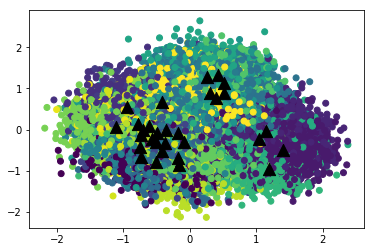

In [40]:
ScatterPlot_by_kmeans(30, d2v_model3_mecab)

## 중간 점검
* 만들어진 Doc2vec 모델을 하나의 뉴스(제목 : 안보전략硏 "황병서·김원홍 '처벌'…공포통치 끝 아닌 시작")로 확인을 해본 결과, 전체적으로 북한 관련 뉴스를 찾아주는 것으로 확인됨